In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
IMAGE_SIZE = 256 #WE check the dataset image size and it is 246x246
BATCH_SIZE = 16 #it's like a standard batch size
CHANNELS = 3
EPOCHS = 10

In [3]:
#loading the dataset from the directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",#the directory that contains the dataset
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=  BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # there are 141 batches each contains 32 images  

135

In [6]:
135 *16 #we get somewhat a big value coz of irregularities in the dataset

2160

(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]
(16, 256, 256, 3)
[0 0 2 1 0 1 1 1 1 0 0 1 2 1 0 2]


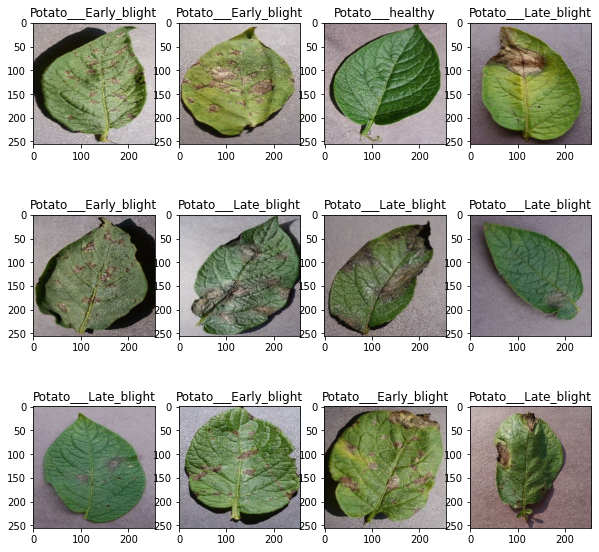

In [7]:
plt.figure(figsize=(10,10)) #increasing the image dispalying area of the output
for image_batch , label_batch in dataset.take(1):#take the first batch of images
    for i in range(12):
        ax = plt.subplot(3,4,i+1)#creating a subplot of 3x4 
        print(image_batch.shape)
        print(label_batch.numpy())
        plt.imshow(image_batch[i].numpy().astype("uint8"))#imshow expects 3D array, astype("uint8") converting float to 8-bit (0-255)
        plt.title(class_names[label_batch[i]])

**there are 32 images and each image is 256x256, and 3 is RGB.
since there are 3 classes(['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']) 0,1 and 2 are the classes in the arrary**

**Train size = 80%;
20% ( 10% validation , 10% test)**

In [8]:
train_size = 0.8
len(dataset)*train_size

108.0

In [9]:
train_ds = dataset.take(112)#take 1st 112 datas of the dataset
len(train_ds)

112

In [10]:
test_ds = dataset.skip(112)#skip the 1st 112 and take the remaining dataset
len(test_ds)

23

In [11]:
val_size = 0.1
val_size*len(dataset)

13.5

In [12]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [13]:
test_ds = test_ds.skip(14)
len(test_ds)

9

In [14]:
#doin all the above in one function
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle =True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)#seed for to get constant values
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [15]:
 train_ds,val_ds,test_ds = get_dataset_partition(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)# BY giving AUTOTUNE we let tensorflow to decide no of batches to load while GPU is training our model
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**cache() will read the image in the disk when you need the same image for the next iteration, it will keep the image in memory. prefetch() if GPU is busy training the model of a batch prefetch will load the next set of batch fro our disk, this will improve our model(model will get train faster)**

## scaling the image

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),#Resizing the image to 256x256 (although we have resized the image it's better to do it again)
    layers.experimental.preprocessing.Rescaling(1.0/255) # Rescaling(1,255) images to (0,1)
])

## Data Augmentation
**data Augmentation when we supply images which are in different angles, rotated or different contrast, our model might not accurately predict therefore we use data augmentation** <br>
**in data augmentation we take an image and add some filters to it(like high contrast, horizontal flip) and train our model(check the video in code basics about data Augmentation)**


In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


## Building the model 
**(Check the video about CNN in codebasics)**

In [36]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape=input_shape),#32 is a trial and error number
    layers.MaxPooling2D((2,2)),
    #all the below layers are derived from trial and error 
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),# flatening the array to one row
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 conv2d_10 (Conv2D)          (256, 254, 254, 32)       896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (256, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (256, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (256, 62, 62, 64)        0         
 g2D)                                                 

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=10,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.74 - 319s 3s/step - loss: 0.8821 - accuracy: 0.7494 - val_loss: 0.4193 - val_accuracy: 0.8000
Epoch 2/10
108/108 [==============================] - 250s 2s/step - loss: 0.2906 - accuracy: 0.8825 - val_loss: 0.3855 - val_accuracy: 0.8500
Epoch 3/10
108/108 [==============================] - 164s 2s/step - loss: 0.2432 - accuracy: 0.9016 - val_loss: 0.2343 - val_accuracy: 0.9150
Epoch 4/10
108/108 [==============================] - 167s 2s/step - loss: 0.2124 - accuracy: 0.9161 - val_loss: 0.3752 - val_accuracy: 0.8550
Epoch 5/10
108/108 [==============================] - 188s 2s/step - loss: 0.1782 - accuracy: 0.9306 - val_loss: 0.2948 - val_accuracy: 0.8800
Epoch 6/10
108/108 [==============================] - 265s 2s/step - loss: 0.1480 - accuracy: 0.9450 - val_loss: 0.5301 - val_accuracy: 0.7600
Epoch 7/10
108/108 [==============================] - 223s 2s/step - loss: 0.2180 - accuracy: 0.9167

In [ ]:
from tensorflow.keras.models import load_model
model.save('model1.h5')

In [ ]:
model_loaded = load_model('model1.h5')

In [41]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 5s 379ms/step - loss: 0.2328 - accuracy: 0.9062


In [42]:
scores

[0.23275874555110931, 0.90625]

In [43]:
history

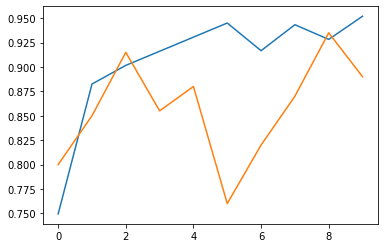

In [46]:
acc = history.history['accuracy'] #values of accuracy of each epoch
val_acc = history.history['val_accuracy']
plt.plot(range(EPOCHS),acc)
plt.plot(range(EPOCHS),val_acc)

1st image to predict
Potato___Late_blight
[9.1538212e-04 9.9106807e-01 8.0165509e-03]
1
Potato___Late_blight


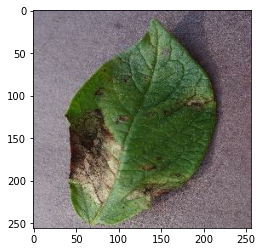

In [59]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]
    print("1st image to predict")
    plt.imshow(first_image)
    print(class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))#gives out the index of highest value
    print(class_names[np.argmax(batch_prediction[0])])

batch_prediction[0] ouputs 3 probabilities and highest prob is the actual class 

In [60]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())#convert image into array
    img_array = tf.expand_dims(img_array,0)#create a batch
    
    prdictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(prdictions[0])]
    confidence = round(100*(np.max(prdictions[0])),2) 
    return predicted_class,confidence

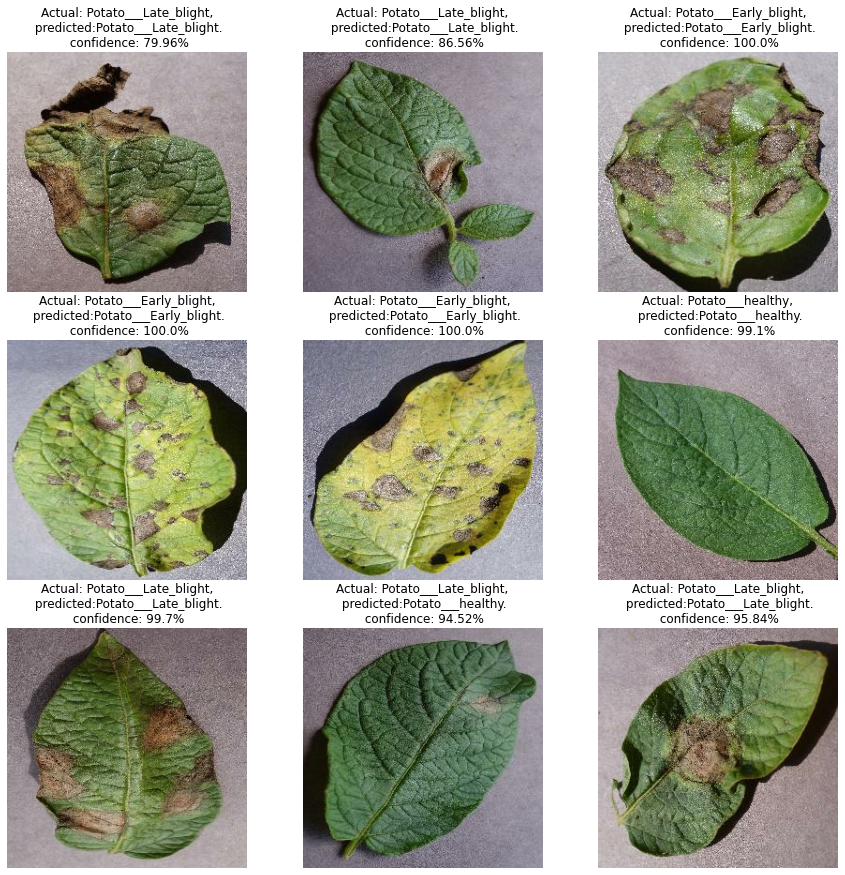

In [66]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n predicted:{predicted_class}.\n confidence: {confidence}%")
        plt.axis("off")